In [3]:
"""
This script loads a pre-trained model and tests for accuracy.
"""

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from pydub import AudioSegment
from scipy.io import wavfile
sns.set()

# Project paths
path_project = "/Users/tikka/Documents/Learning/Projects/kido/"
path_test = path_project + "batch99_test/"
path_audio = path_test + "audio/"
path_splits = path_test + "splits/"
path_images = path_test + "images/"
path_model = path_test + "model/"
path_figures = path_project + "figures/"

# Load the trained CNN model
# https://www.tensorflow.org/tutorials/keras/save_and_load
# Recreate the exact same model saved in .h5, including its weights and the optimizer
model = keras.models.load_model(path_model + 'kido_v1_20191016.h5')
# Show the model architecture
#model.summary()

In [4]:
# Create a spectrogram
# https://stackoverflow.com/questions/47147146/
# save-an-image-only-content-without-axes-or-anything-else-to-a-file-using-matl
# https://stackoverflow.com/questions/34162443/
# why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python
def graph_spectrogram(input_path, wav_file, output_path, output_fname, close_fig = True):
    rate, data = wavfile.read(input_path + wav_file)
    data1D = data[:, 0]
    fig, ax = plt.subplots(1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    pxx, freqs, bins, im = ax.specgram(x=data1D, Fs=rate, noverlap=384, NFFT=512)
    ax.axis('off')
    fig.savefig(output_path + output_fname, dpi=300, frameon='false')
    if close_fig:
        matplotlib.pyplot.close(fig)

In [5]:
# List of words to be hacked
list_audio = os.listdir(path_audio)
list_m4a = [file for file in list_audio if file.endswith('.m4a')]
list_wav = [file for file in list_audio if file.endswith('.wav')]
list_words = [file[:-4] for file in list_m4a]
# --
list_splits = os.listdir(path_splits)
list_images = os.listdir(path_images)

# Loop through the words
dic_Original_Predicted = {}
for word in list_words:
    # Does the audio .m4a exist?
    file_m4a = word + '.m4a'
    if file_m4a not in list_m4a:
        print('First create the audio input:', file_m4a)
        exit()
    
    # Is the word audio .m4a already converted to .wav?
    file_wav = word + '.wav'
    if file_wav not in list_wav:
        # Convert m4a(=mp4) to wav (need to install pydub and ffmpeg)
        # https://pythonbasics.org/convert-mp3-to-wav/
        # https://www.youtube.com/watch?v=8nbuqYw2OCw
        # https://github.com/jiaaro/pydub
        audio = AudioSegment.from_file(path_audio + file_m4a, "mp4")
        audio.export(path_audio + file_wav, "wav")
        
    # Is the audio file already split?
    list_chunks = []
    n_chars = len(word)
    for i in range(n_chars):
        split_wav = word + "_chunk" + str(i) + "_" + word[i] + ".wav"
        list_chunks.append(split_wav)
    all_splits_exist = True
    for file_ in list_chunks:
        if file_ not in list_splits:
            all_splits_exist = False
            break
    if not all_splits_exist:
        # Split
        audio = AudioSegment.from_wav(path_audio + file_wav)
        average_loudness = audio.dBFS
        chunks = split_on_silence(
            # Audio to be split
            audio,

            # Specify that a silence chunk must be at least 100ms long
            min_silence_len = 100,

            # Consider a chunk silent if it's quieter than x-dBFS
            silence_thresh = average_loudness - 10,

            # Keep some silence padding
            keep_silence = 100
        )
        # Do the number of chunks match with number of chars
        n_chunks = len(chunks)
        if n_chunks == n_chars:
            # Export the chunks
            for i in range(len(chunks)):
                chunks[i].export(path_splits + word + "_chunk" + str(i) + "_" + word[i] + ".wav", "wav")
        else:
            print('Failed splitting:', file_wav)
            continue
            
    # Splits converted to spectrogram images?
    list_chunkImages = [file[:-4]+'.png' for file in list_chunks]
    all_images_exist = True
    for file_ in list_chunkImages:
        if file_ not in list_images:
            all_images_exist = False
            break
    if not all_images_exist:
        # Create the spectrogram images
        for file_ in list_chunks:
            fname = file_[:-4]
            file_png = fname + '.png'
            graph_spectrogram(path_splits, file_, path_images, file_png)
            
    # Predict
    predicted_word = ''
    for file_ in list_chunkImages:
        # Read the image file
        img = image.load_img(path_images+file_, target_size=(150, 150))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])
        classes = model.predict(images)
        #print(classes)
        max_index = classes.argmax()
        predicted_char = chr(max_index + ord('a'))
        predicted_word += predicted_char

    # Original vs predicted
    dic_Original_Predicted[word] = predicted_word
    print('.', end='')

........................................................................................................................................................................................................

In [6]:
def accuracy(dic):
    count_total = 0
    count_wrong = 0
    count_right = 0
    count_word_miss = 0
    dic_accuracy = {}
    list_accurate = []
    for key in dic:
        word_miss = False
        word_ = ''
        for i in range(len(key)):
            if key[i] == dic[key][i]:
                word_ += key[i]
            else:
                word_ += '_'
                word_miss = True
        if word_miss: count_word_miss += 1
        if not word_miss: list_accurate.append(key)
        count_total += len(key)
        count_wrong += word_.count('_')
        count_right += len(word_) - word_.count('_')
        dic_accuracy[key] = (dic[key], word_)

    # Check, the counts should match
    if count_total != count_wrong + count_right:
        print("The counts aren't right:", count_total, count_wrong, count_right)
        exit()
    
    # Calculate the accuracy
    char_accuracy = count_right * 100/ count_total
    word_accuracy = (len(dic) - count_word_miss) * 100 / len(dic)
    list_accurate.sort()
    return char_accuracy, word_accuracy, dic_accuracy, list_accurate
            


In [7]:
import autocorrect
from autocorrect import Speller

#using autocorrect to improve prediction accuracy
# https://github.com/fsondej/autocorrect
spell = Speller(lang='en')
dic_Original_Autocorrected = {}
for key in dic_Original_Predicted:
    predicted = dic_Original_Predicted[key]
    autocorrected = spell(predicted)
    dic_Original_Autocorrected[key] = autocorrected if len(autocorrected) == len(predicted) else predicted
    print('.', end='')



........................................................................................................................................................................................................

In [8]:
# Accuracy
char_accuracy, word_accuracy, dic_accuracyPredicted, list_accuPred = accuracy(dic_Original_Predicted)
print('{0:25s} {1:.1f} {2:5.1f}'.format('Predicted accuracy:', char_accuracy, word_accuracy))
print(list_accuPred)
char_accuracy, word_accuracy, dic_accuracyAutocorrected, list_accuAuto = accuracy(dic_Original_Autocorrected)
print('{0:25s} {1:.1f} {2:5.1f}'.format('Autocorrected accuracy:', char_accuracy, word_accuracy))
print(list_accuAuto)


Predicted accuracy:       48.8   1.5
['lokita', 'passion', 'shopping']
Autocorrected accuracy:   49.1   7.5
['billabong', 'canada', 'chance', 'chubby', 'cynthia', 'dreams', 'jackass', 'lucky', 'marian', 'oscar', 'passion', 'playgirl', 'puppies', 'shopping', 'willow']


In [9]:
def formatted_out(dic_accuracyPredicted, dic_accuracyAutocorrected):
    for key in dic_accuracyPredicted:
        w0 = key
        w1 = dic_accuracyPredicted[key][0]
        w2 = dic_accuracyAutocorrected[key][0]
        w1_ = dic_accuracyPredicted[key][1]
        w2_ = dic_accuracyAutocorrected[key][1]
        print('{0:24s} {1:24s} {2:24s}'.format(' '.join(w0), ' '.join(w1), ' '.join(w1_)))
        print('{0:24s} {1:24s} {2:24s}'.format(' '.join(''), ' '.join(w2), ' '.join(w2_)))
        print('\n')
        
formatted_out(dic_accuracyPredicted, dic_accuracyAutocorrected)

a a r o n                s s i o b                _ _ _ o _               
                         s s i o b                _ _ _ o _               


a b c d e f g            x b x x e q g            _ b _ _ e _ g           
                         x b x x e q g            _ b _ _ e _ g           


a m b e r                a k b e b                a _ b e _               
                         a k b e b                a _ b e _               


a m e l i a              a k b l b a              a _ _ l _ a             
                         a k b l b a              a _ _ l _ a             


a m i g a s              a n s n x s              a _ _ _ _ s             
                         a n s n x s              a _ _ _ _ s             


a m i s t a d            a n k s b x n            a _ _ s _ _ _           
                         a n k s b x n            a _ _ s _ _ _           


a n d e r s o n          a c w s n s p n          a _ _ _ _ s _ n         
             

In [12]:
def formatted_out2(list_words, list_accuPred, list_accuAuto):
    for word in list_words:
        w1 = 'x' if word in list_accuPred else '_'
        w2 = 'x' if word in list_accuAuto else '_'
        print('{0:12s} {1:6s} {2:6s}'.format(word, w1, w2))

formatted_out2(list_words, list_accuPred, list_accuAuto)

aaron        _      _     
abcdefg      _      _     
amber        _      _     
amelia       _      _     
amigas       _      _     
amistad      _      _     
anderson     _      _     
angelina     _      _     
apple        _      _     
ariana       _      _     
armando      _      _     
babylove     _      _     
badgirl      _      _     
baller       _      _     
bambam       _      _     
batista      _      _     
bella        _      _     
bestfriends  _      _     
bettyboop    _      _     
beyonce      _      _     
bhebhe       _      _     
billabong    _      x     
biteme       _      _     
blessed      _      _     
booger       _      _     
bradley      _      _     
broken       _      _     
bryan        _      _     
bubblegum    _      _     
butter       _      _     
buttercup    _      _     
caitlin      _      _     
california   _      _     
canada       _      x     
candy        _      _     
capricorn    _      _     
carebear     _      _     
c

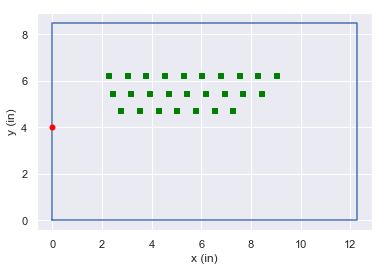

In [14]:
# Read the keyboard coordinates
def keyboard_coordinates(csv_file):
    dic_coordinates = {}
    with open(csv_file, 'r') as fp:
        line = fp.readline().strip()
        while line:
            items = line.split(',')
            dic_coordinates[items[0]] = (float(items[1]), float(items[2]))
            line = fp.readline().strip()
    return dic_coordinates

# Read the coordinates
coordiantes = path_project + 'resources/keyboard.csv'
dic_coordinates = keyboard_coordinates(coordiantes)


# Keyboard layout
# --
# x y labels
plt.xlabel('x (in)')
plt.ylabel('y (in)')
# --
# Draw the keyboard
x1 = 0.0
x2 = dic_coordinates['rect'][0]
y1 = 0.0
y2 = dic_coordinates['rect'][1]
kb_x = [x1, x2, x2, x1, x1]
kb_y = [y1, y1, y2, y2, y1]
plt.plot(kb_x, kb_y, 'b', label='Keyboard')
# --
# Mark the mic
xm = dic_coordinates['mic'][0]
ym = dic_coordinates['mic'][1]
plt.plot([xm], [ym], marker='o', markersize=5, color="red", label='Mic')
# --
# Mark the char-keys
for i in range(26):
    key = chr(i + ord('a'))
    x = dic_coordinates[key][0]
    y = dic_coordinates[key][1]
    #print(i, key, x, y)
    plt.plot([x], [y], marker='s', markersize=5, color="green")
#plt.savefig(path_figures + 'KeyboardLayout.png', dpi = 1000)

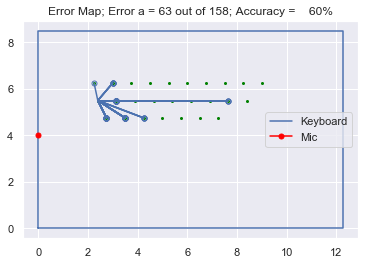

<Figure size 432x288 with 0 Axes>

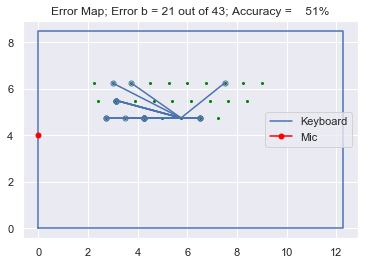

<Figure size 432x288 with 0 Axes>

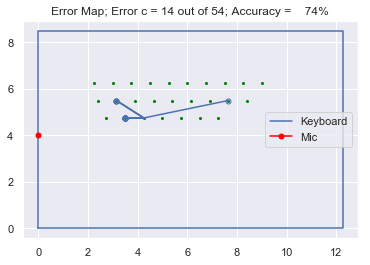

<Figure size 432x288 with 0 Axes>

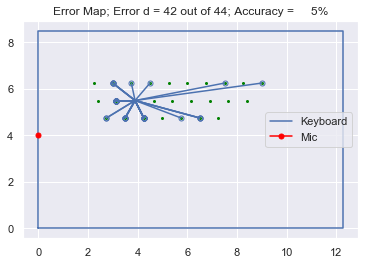

<Figure size 432x288 with 0 Axes>

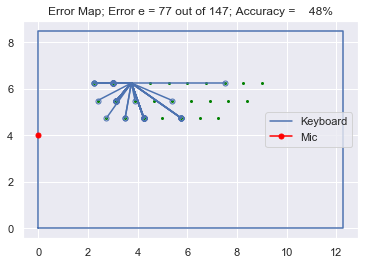

<Figure size 432x288 with 0 Axes>

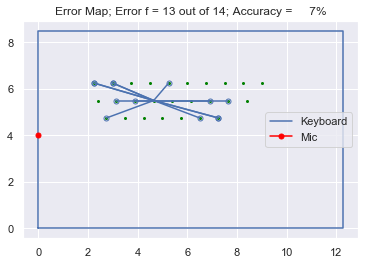

<Figure size 432x288 with 0 Axes>

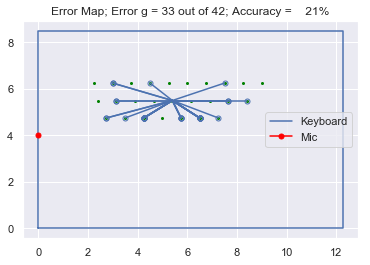

<Figure size 432x288 with 0 Axes>

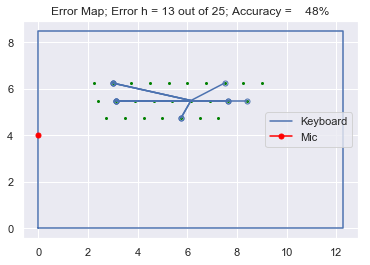

<Figure size 432x288 with 0 Axes>

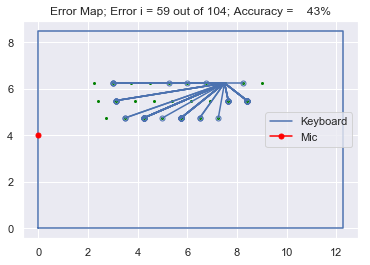

<Figure size 432x288 with 0 Axes>

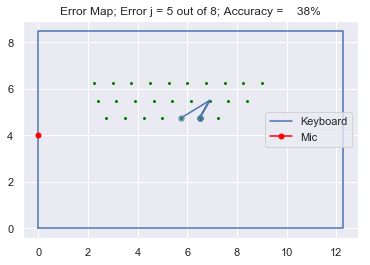

<Figure size 432x288 with 0 Axes>

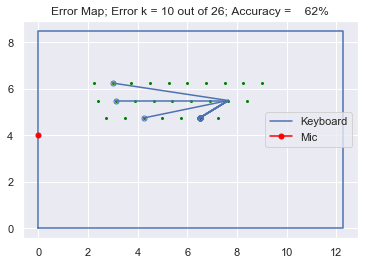

<Figure size 432x288 with 0 Axes>

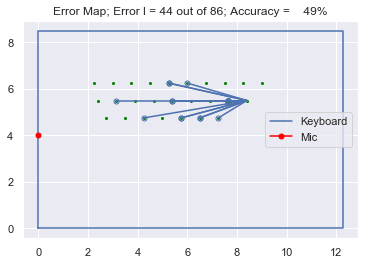

<Figure size 432x288 with 0 Axes>

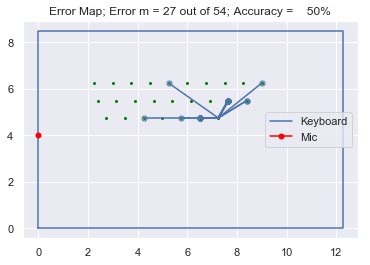

<Figure size 432x288 with 0 Axes>

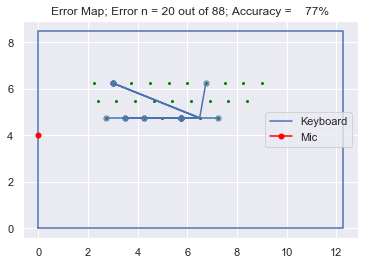

<Figure size 432x288 with 0 Axes>

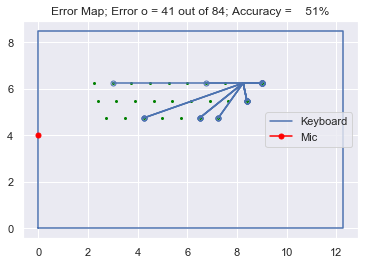

<Figure size 432x288 with 0 Axes>

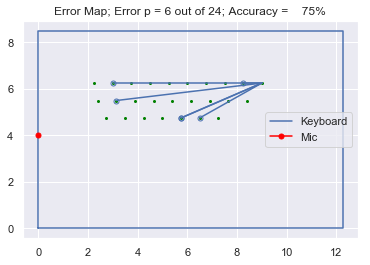

<Figure size 432x288 with 0 Axes>

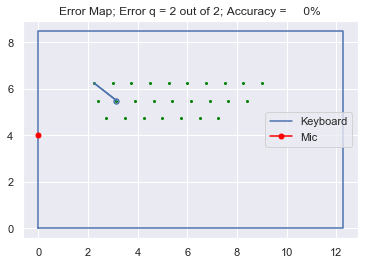

<Figure size 432x288 with 0 Axes>

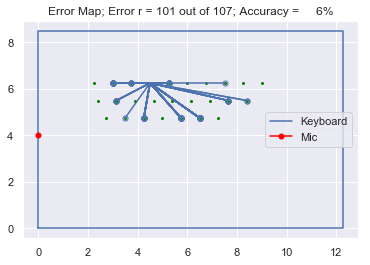

<Figure size 432x288 with 0 Axes>

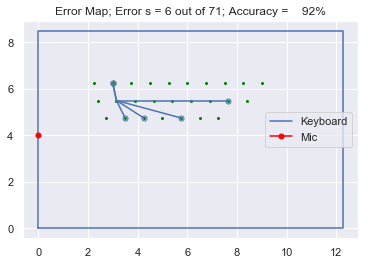

<Figure size 432x288 with 0 Axes>

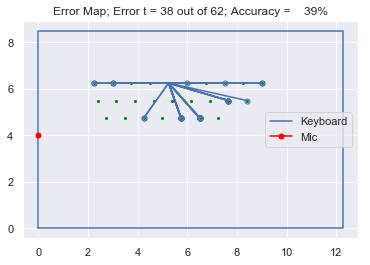

<Figure size 432x288 with 0 Axes>

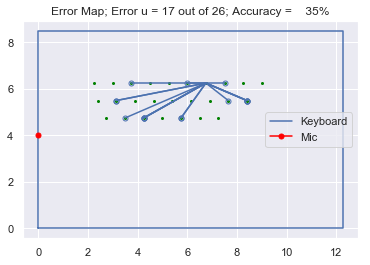

<Figure size 432x288 with 0 Axes>

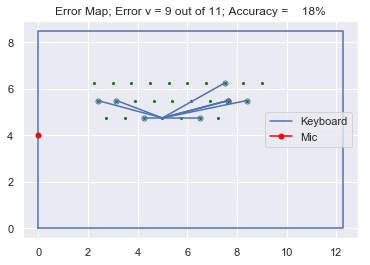

<Figure size 432x288 with 0 Axes>

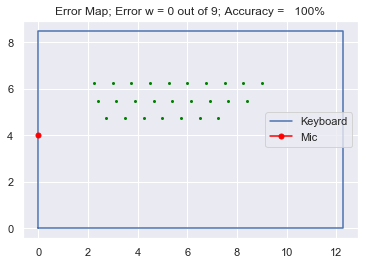

<Figure size 432x288 with 0 Axes>

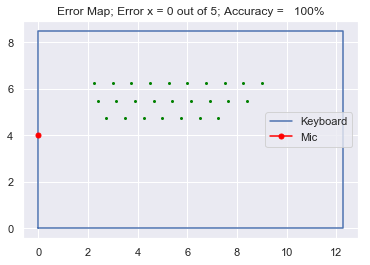

<Figure size 432x288 with 0 Axes>

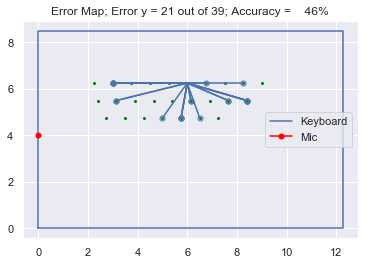

<Figure size 432x288 with 0 Axes>

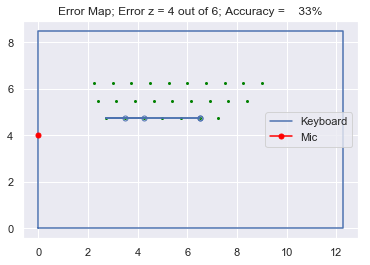

<Figure size 432x288 with 0 Axes>

In [16]:
# Error map

# Calculate the error vectors
def error_vectors(dic_Original_Predicted, dic_coordinates):
    list_errors = []
    for key, val in dic_Original_Predicted.items():
        #print(key, val)
        for i in range(len(key)):
            if key[i] != val[i]:
                #print(key[i], val[i])
                x = [dic_coordinates[key[i]][0], dic_coordinates[val[i]][0]]
                y = [dic_coordinates[key[i]][1], dic_coordinates[val[i]][1]]
                list_errors.append((x,y))
    return(list_errors)

# Calculate error vectors for a given char
def error_vectors_char(dic_Original_Predicted, dic_coordinates, char):
    list_errors = []
    count_wrong = 0
    count_right = 0
    for key, val in dic_Original_Predicted.items():
        #print(key, val)
        for i in range(len(key)):
            if key[i] != val[i] and key[i] == char:
                #print(key[i], val[i])
                x = [dic_coordinates[key[i]][0], dic_coordinates[val[i]][0]]
                y = [dic_coordinates[key[i]][1], dic_coordinates[val[i]][1]]
                list_errors.append((x,y))
                count_wrong += 1
            elif key[i] == val[i] and key[i] == char:
                count_right += 1
    return(list_errors, count_wrong, count_right)

# Error map
for j in range(26):
    error_char = chr(j + ord('a'))
    coordiantes = path_project + 'resources/keyboard.csv'
    dic_coordinates = keyboard_coordinates(coordiantes)
    list_errors, count_wrong, count_right = error_vectors_char(
        dic_Original_Predicted, dic_coordinates, error_char
    )
    # --
    # Draw the keyboard
    x1 = 0.0
    x2 = dic_coordinates['rect'][0]
    y1 = 0.0
    y2 = dic_coordinates['rect'][1]
    kb_x = [x1, x2, x2, x1, x1]
    kb_y = [y1, y1, y2, y2, y1]
    plt.plot(kb_x, kb_y, 'b', label='Keyboard')
    # --
    # Mark the mic
    xm = dic_coordinates['mic'][0]
    ym = dic_coordinates['mic'][1]
    plt.plot([xm], [ym], marker='o', markersize=5, color="red", label='Mic')
    # --
    # Mark the char-keys
    for i in range(26):
        key = chr(i + ord('a'))
        x = dic_coordinates[key][0]
        y = dic_coordinates[key][1]
        #print(i, key, x, y)
        plt.plot([x], [y], marker='o', markersize=2, color="green")
    # --
    # Plot the error vectors
    for xy in list_errors:
        x = xy[0]
        y = xy[1]
        plt.plot(x, y, 'b')
        plt.plot(x[1], y[1], marker='o', fillstyle = 'none', markersize=5, color='b')

    count_total = count_wrong + count_right
    pct_error = count_wrong * 100 / count_total
    pct_accuracy = 100. - pct_error
    plt.title('Error Map; Error {0:} = {1:} out of {2:}; Accuracy = {3:5.0f}%'.format(error_char, count_wrong, count_total, pct_accuracy) )
    plt.legend(loc=0)
    plt.grid(True)
    #plt.savefig(path_figures + 'ErrorMap_' + error_char + '.png', dpi = 1000)
    plt.figure()
    plt.show()

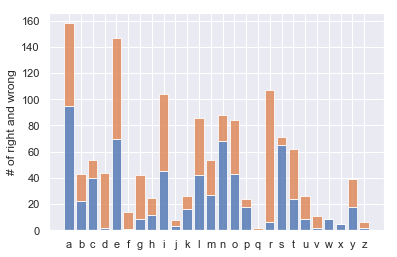

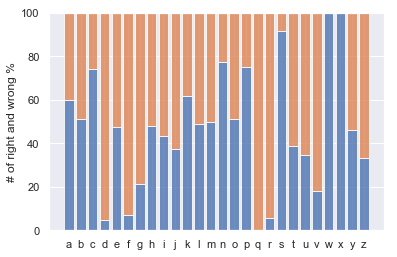

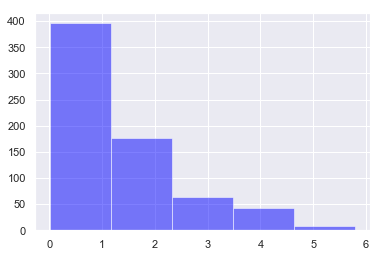

[396. 176.  64.  42.   8.]
--
[0.0184381  1.17236581 2.32629352 3.48022123 4.63414894 5.78807665]
--
<a list of 5 Patch objects>


In [20]:
import math

# Error data for bar chart by chr, and histogram
def error_bar_histo(dic_Original_Predicted, dic_coordinates):
    list_right = []
    list_wrong = []
    list_right_pct = []
    list_wrong_pct = []
    list_dist_chr = []
    list_dist_err = []
    for i in range(26):
        # Error vector
        char = chr(i + ord('a'))
        list_errors, count_wrong, count_right = error_vectors_char(dic_Original_Predicted, dic_coordinates, char)
        
        # Data for bar chart
        list_right.append(count_right)
        list_wrong.append(count_wrong)
        total = count_right + count_wrong
        right_pct = count_right * 100 / total
        wrong_pct = count_wrong * 100 / total
        list_right_pct.append(right_pct)
        list_wrong_pct.append(wrong_pct)
        
        # Data for histogram
        # --
        # Mic coordinates
        xm = dic_coordinates['mic'][0]
        ym = dic_coordinates['mic'][1]
        #print(xm, ym)
        # --
        # Distance of the chr from the mic
        x = dic_coordinates[char][0]
        y = dic_coordinates[char][1]
        d = math.sqrt((xm - x)**2 + (ym - y)**2)
        list_dist_chr.append(d)
        #print(char, x, y, d)
        # Dist of the errors from the mic
        for item in list_errors:
            xi = item[0][1]
            yi = item[1][1]
            di = math.sqrt((xm - xi)**2 + (ym - yi)**2)
            # Difference in dist
            da = abs(di - d)
            list_dist_err.append(da)
            #print('--', item[0][0], item[1][0], di, da, xi, yi)
    
    return list_right, list_wrong, list_right_pct, list_wrong_pct, list_dist_chr, list_dist_err

# Bar chart for the number of right and wrong
list_right, list_wrong, list_right_pct, list_wrong_pct, list_dist_chr, list_dist_err = error_bar_histo(
    dic_Original_Predicted, dic_coordinates
)
# --
bottom1 = list_right
labels = [chr(i + ord('a')) for i in range(26)]
x = [i for i in range(26)]
plt.bar(x, list_right, align='center', alpha=0.8)
plt.bar(x, list_wrong, bottom = bottom1, align='center', alpha=0.8)
plt.xticks(x, labels)
plt.ylabel('# of right and wrong')
#plt.savefig(path_figures + 'RightAndWrong.png', dpi = 1000)
plt.show()
# --
bottom2 = list_right_pct
labels = [chr(i + ord('a')) for i in range(26)]
x = [i for i in range(26)]
plt.bar(x, list_right_pct, align='center', alpha=0.8)
plt.bar(x, list_wrong_pct, bottom = bottom2, align='center', alpha=0.8)
plt.xticks(x, labels)
plt.ylabel('# of right and wrong %')
#plt.savefig(path_figures + 'RightAndWrongPct.png', dpi = 1000)
plt.show()
# --
num_bins = 5
n, bins, patches = plt.hist(list_dist_err, num_bins, facecolor='blue', alpha=0.5)
plt.show()
print(n)
print('--')
print(bins)
print('--')
print(patches)





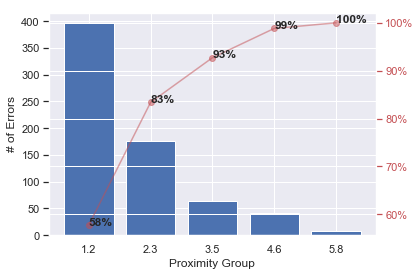

In [21]:
# Pareto plot
import pandas as pd

# https://tylermarrs.com/posts/pareto-plot-with-matplotlib/
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()
    
    fig, ax1 = plt.subplots()
    ax1.bar(x, y)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5)
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')
    
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])
    
    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]), fontweight='heavy')    
    
    if title:
        plt.title(title)
    
    plt.tight_layout()
    #plt.savefig(path_figures + 'ErrorPareto.png', dpi = 1000)
    plt.show()
    
df = pd.DataFrame({
    'Proximity Group': [str("{0:.1f}".format(b)) for b in bins[1:]],
    '# of Errors': n
})
pareto_plot(df, x='Proximity Group', y='# of Errors', show_pct_y=True)

[ 0 25 16 18 23 22  3  2  4  5 17 21  6 19  1  7 24 13  9 20 12 10  8 11
 14 15]


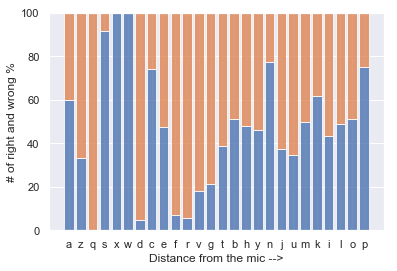

In [38]:
import numpy

# Does error correlate with distance from the mic
vals = numpy.array(list_dist_chr)
sort_index = numpy.argsort(vals)
print(sort_index)

list_sortedDist_char = []
list_sortedDist_RightPct = []
list_sortedDist_WrongPct = []
for item in sort_index:
    list_sortedDist_char.append(chr(item + ord('a')))
    list_sortedDist_RightPct.append(list_right_pct[item])
    list_sortedDist_WrongPct.append(list_wrong_pct[item])

labels = list_sortedDist_char
x = [i for i in range(26)]
plt.bar(x, list_sortedDist_RightPct, align='center', alpha=0.8)
plt.bar(x, list_sortedDist_WrongPct, bottom = list_sortedDist_RightPct, align='center', alpha=0.8)
plt.xticks(x, labels)
plt.ylabel('# of right and wrong %')
plt.xlabel('Distance from the mic -->')
plt.savefig(path_figures + 'RightWrongPct_Vs_DistFromMic.png', dpi = 1000)
plt.show()
